# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2022-01-25 09:30:48--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Распознаётся ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Подключение к ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 182040794 (174M) [text/plain]
Сохранение в каталог: ««train_32x32.mat»».

train_32x32.mat     100%[===================>] 173,61M  5,30MB/s    за 36s     

2022-01-25 09:31:24 (4,89 MB/s) - «train_32x32.mat» сохранён [182040794/182040794]

--2022-01-25 09:31:24--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Повторное использование соединения с ufldl.stanford.edu:80.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 64275384 (61M) [text/plain]
Сохранение в каталог: ««test_32x32.mat»».

test_32x32.mat      100%[===================>]  61,30M  4,85MB/s    за 13s     

2022-01-25 09:31:38 (4,62 MB/s) - «test_32x32.mat» сохранён [64275384/64275384]

ЗАВЕРШЕНО --2022-01-25 09:31:3

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms
from pytorch_helper import PyTorchHelper

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                         std=[0.20,0.20,0.20])                   
])

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./', transform=_transform)
data_test = dset.SVHN('./', split='test', transform=_transform)

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64
helper = PyTorchHelper(batch_size,  data_train)

train_indices, val_indices = helper.split(.2)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [9]:
loss_history, train_history, val_history = helper.train_model('model_1', nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.394117, Train accuracy: 0.537761, Val accuracy: 0.762883
Average loss: 0.700755, Train accuracy: 0.785534, Val accuracy: 0.806771
Average loss: 0.598615, Train accuracy: 0.821162, Val accuracy: 0.824039
Average loss: 0.552233, Train accuracy: 0.835853, Val accuracy: 0.790594
Average loss: 0.519903, Train accuracy: 0.846125, Val accuracy: 0.827793


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [10]:
def print_augmentation(list_tfs):
    tfs = transforms.Compose(list_tfs)
    
    data_vis = dset.SVHN('./')
    data_aug_vis = dset.SVHN('./', transform=tfs)

    plt.figure(figsize=(30, 3))

    num_samples = 20

    for i, ((x, _), (x_aug, _)) in enumerate(zip(data_vis, data_aug_vis)):
        if i == num_samples:
            break
        plt.subplot(2, num_samples, i + 1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.grid(False)
        plt.imshow(x_aug)
        plt.axis('off')

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:1248: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


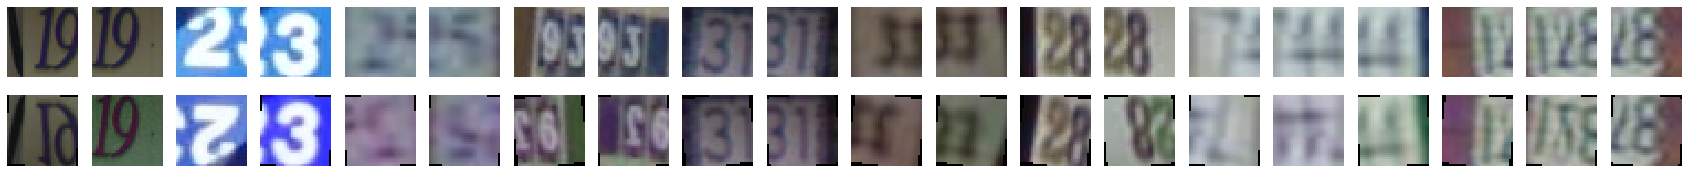

In [11]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

list_tfs = [
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
]
print_augmentation(list_tfs)

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

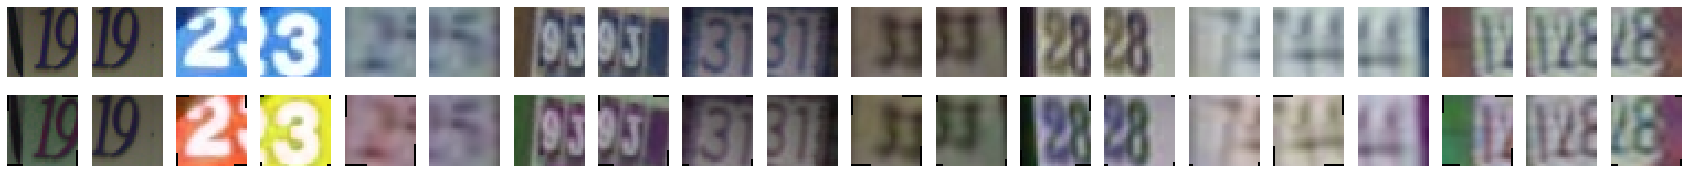

In [12]:
list_tfs = [
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(5, resample=PIL.Image.BILINEAR),
]
print_augmentation(list_tfs)

In [13]:
# TODO: 
list_tfs.append(transforms.ToTensor())
list_tfs.append(transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]))

tfs = transforms.Compose(list_tfs)

# TODO create new instances of loaders with the augmentations you chose

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [14]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = helper.train_model('model_2', nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.566821, Train accuracy: 0.827646, Val accuracy: 0.816463
Average loss: 0.523827, Train accuracy: 0.840324, Val accuracy: 0.850044


KeyboardInterrupt: 

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
def base_lenet():
    return nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  
            
            Flattener(),

            nn.Linear(16*5*5, 120), 
            nn.ReLU(inplace=True),

            nn.Linear(120, 84),
            nn.ReLU(inplace=True),

            nn.Linear(84, 10),
          )

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = base_lenet()

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = helper.train_model('lenet_base', lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

# Подбор гиперпараметров

In [ ]:
from itertools import product

In [ ]:
def find_hyperparameters(config):
    # The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
    # We also encourage you to try different optimizers as well

    Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
    RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

    learning_rates = [1e-1]
    anneal_coeff = 0.2
    anneal_epochs = [5]
    regs = config['regs']
    optimizers = config['optimizers']

    batch_size = 64
    epoch_num = 10

    # Record all the runs here
    # Key should be Hyperparams and values should be RunResult
    run_record = {} 

    # Use grid search or random search and record all runs in run_record dictionnary 
    # Important: perform search in logarithmic space!

    # TODO: Your code here!

    best_hyperparams = Hyperparams(None, None, None)
    best_result = RunResult(None, None, None, None)

    for lr, reg, anneal_epoch, optimizer in product(learning_rates, regs, anneal_epochs, optimizers):
        lenet_model = config['model']() # base_lenet()

        lenet_model.type(torch.cuda.FloatTensor)
        lenet_model.to(device)

        loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

        optimizer = optimizer(lenet_model.parameters(), lr=lr, weight_decay=reg)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)

        params = Hyperparams(lr, anneal_epoch, reg)

        print(f"\nCurrent hyperparams: {params}")

        loss_history, train_history, val_history = helper.train_model(config['model_name'],lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

        result = RunResult(lenet_model, train_history, val_history, val_history[-1])
        run_record[params] = result

        if best_result.final_val_accuracy is None or best_result.final_val_accuracy < result.final_val_accuracy:
            best_result = result
            best_hyperparams = params

        print("\nCurrent best validation accuracy: %4.2f, best hyperparams: %s" % (best_result.final_val_accuracy, best_hyperparams))
        
    return run_record, best_result

In [ ]:
import random

In [ ]:
config = {
    'regs': [0.0001],
    'optimizers': [optim.SGD],
    'model': base_lenet,
    'model_name': 'best_lenet'    
}

In [ ]:
run_record, best_result = find_hyperparameters(config)

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        